In [2]:
import pyart
import os
from glob import glob
import numpy as np


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
output_folder = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_CASCV_subset_level1b/'

/g/data/kl02/jss548/hail-research/hailsonde/20230724_CASCV_subset/2023072422_24_ODIMH5_PVOL6S_VOL_CASCV.h5


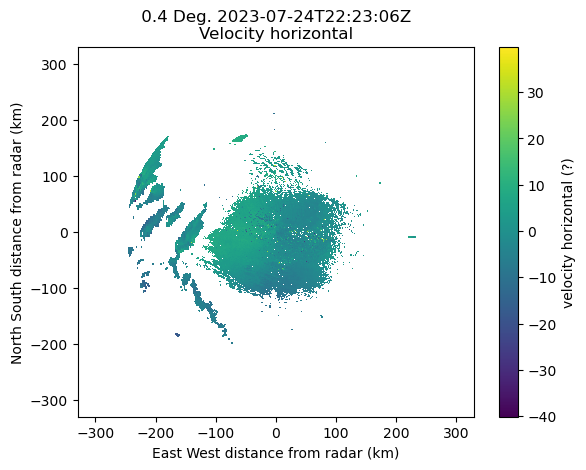

In [16]:
odimh5_ffn_list = sorted(glob('/g/data/kl02/jss548/hail-research/hailsonde/20230724_CASCV_subset/*.h5'))
for odimh5_ffn in odimh5_ffn_list:
    print(odimh5_ffn)
    radar = pyart.aux_io.read_odim_h5(odimh5_ffn)

    #reorder
    sweep_sort_idx = np.argsort(radar.fixed_angle['data'])
    radar = radar.extract_sweeps(sweep_sort_idx)

    #fields to keep
    fields_to_keep = ['reflectivity_horizontal', 'velocity_horizontal']
    field_name_list = list(radar.fields.keys())
    for field_name in field_name_list:
        if field_name not in fields_to_keep:
            radar.fields.pop(field_name)
    #remove any nan and hard set mask
    refl = radar.fields['reflectivity_horizontal']['data']
    refl[np.isnan(refl)] = -9999
    refl[np.ma.getmask(refl)] = -9999
    radar.fields['reflectivity_horizontal']['data'] = refl

    #remove any nan and hard set mask
    vel = radar.fields['velocity_horizontal']['data']
    vel[np.isnan(vel)] = -9999
    vel[np.ma.getmask(vel)] = -9999
    radar.fields['velocity_horizontal']['data'] = vel

    #resample
    new_refl = None
    new_vel = None
    new_azi = None
    new_time = None
    new_elv = None
    new_start = None
    new_end = None
    for i in range(len(sweep_sort_idx)):
        ray_slice = radar.get_slice(i)
        refl_sweep = radar.fields['reflectivity_horizontal']['data'][ray_slice]
        vel_sweep = radar.fields['velocity_horizontal']['data'][ray_slice]
        azi_sweep = radar.azimuth['data'][ray_slice]
        time_sweep = radar.time['data'][ray_slice]
        elv_sweep = radar.elevation['data'][ray_slice]
        if np.shape(refl_sweep)[0] != 360:
            refl_sweep = refl_sweep[::2,:]
            vel_sweep = vel_sweep[::2,:]
            azi_sweep = azi_sweep[::2]
            time_sweep = time_sweep[::2]
            elv_sweep = elv_sweep[::2]
        
        if new_refl is None:
            new_refl = refl_sweep
            new_vel = vel_sweep
            new_azi = azi_sweep
            new_time = time_sweep
            new_elv = elv_sweep
            new_start = [0]
            new_end = [len(azi_sweep) - 1]
        else:
            new_start.append(len(new_azi))
            new_end.append(len(new_azi)+ len(azi_sweep) - 1)
            new_refl = np.vstack((new_refl, refl_sweep))
            new_vel = np.vstack((new_vel, vel_sweep))
            new_azi = np.hstack((new_azi, azi_sweep))
            new_time = np.hstack((new_time, time_sweep))
            new_elv = np.hstack((new_elv, elv_sweep))
    radar.fields['reflectivity_horizontal']['data'] = new_refl
    radar.fields['velocity_horizontal']['data'] = new_vel
    radar.azimuth['data'] = new_azi
    radar.time['data'] = new_time
    radar.elevation['data'] = new_elv
    radar.nrays = len(new_azi)
    radar.sweep_start_ray_index['data'] = np.array(new_start)
    radar.sweep_end_ray_index['data'] = np.array(new_end)

    #reassign data masks
    refl = radar.fields['reflectivity_horizontal']['data']
    radar.fields['reflectivity_horizontal']['data'] = np.ma.masked_array(refl, mask=refl==-9999)
    vel = radar.fields['velocity_horizontal']['data']
    radar.fields['velocity_horizontal']['data'] = np.ma.masked_array(vel, mask=vel==-9999)

    disp = pyart.graph.RadarDisplay(radar)
    disp.plot_ppi('velocity_horizontal',0)

    pyart.io.write_cfradial(f'{output_folder}/{os.path.basename(odimh5_ffn)[:-3]}_ppi.nc', radar)
    break
        

sweep_start_ray_index: [   0  360  720 1080 1440 1800 2160 2520 2880 3240 3600 3960 4320 4680
 5040 5400 5760]
sweep_end_ray_index: [ 359  719 1079 1439 1799 2159 2519 2879 3239 3599 3959 4319 4679 5039
 5399 5759 6119]
[810.40002441]


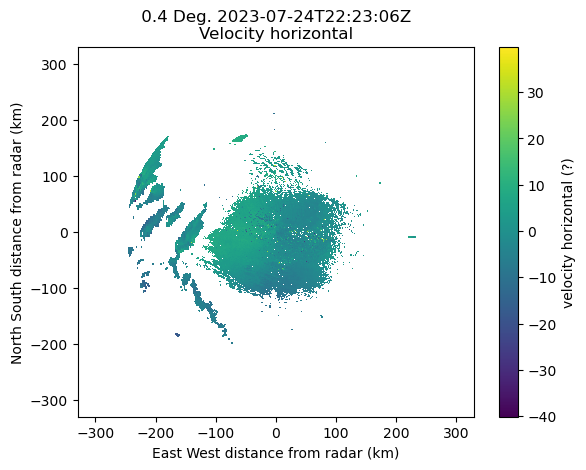

In [20]:
#inspect file
radar = pyart.io.read('/g/data/kl02/jss548/hail-research/hailsonde/20230724_CASCV_subset_level1b/2023072422_24_ODIMH5_PVOL6S_VOL_CASCV_ppi.nc')
print('sweep_start_ray_index:', radar.sweep_start_ray_index['data'])
print('sweep_end_ray_index:', radar.sweep_end_ray_index['data'])
disp = pyart.graph.RadarDisplay(radar)
disp.plot_ppi('velocity_horizontal',0)

print(radar.altitude['data'])